In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import pandas as pd

ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id="12c66783-9633-4764-9fc9-e75b5efcde68",
    resource_group_name="rg-ruap-nogomet-v2",
    workspace_name="aml-ruap-nogomet-v2"
)

data_asset = ml_client.data.get("matches_final", version="1")

print(data_asset.path)


Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


azureml://subscriptions/12c66783-9633-4764-9fc9-e75b5efcde68/resourcegroups/rg-ruap-nogomet-v2/workspaces/aml-ruap-nogomet-v2/datastores/workspaceblobstore/paths/UI/2026-01-31_145551_UTC/matches_final.csv/


In [4]:
df = pd.read_csv(data_asset.path)
df.shape
df.head()

,season,date,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,...,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayDribbling,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,2008/2009,2008-07-18,1.0,2.0,4.0,6.0,8.0,3.0,5.0,6.0,...,52.0,52.0,49.0,49.0,52.0,53.0,54.0,46.0,48.0,52.0
1,2008/2009,2008-07-19,1.0,2.0,4.0,6.0,8.0,3.0,5.0,6.0,...,52.0,52.0,49.0,49.0,52.0,53.0,54.0,46.0,48.0,52.0
2,2008/2009,2008-07-20,1.0,2.0,4.0,6.0,8.0,3.0,5.0,6.0,...,52.0,52.0,49.0,49.0,52.0,53.0,54.0,46.0,48.0,52.0
3,2008/2009,2008-07-20,1.0,2.0,4.0,6.0,8.0,3.0,5.0,6.0,...,52.0,52.0,49.0,49.0,52.0,53.0,54.0,46.0,48.0,52.0
4,2008/2009,2008-07-23,1.0,2.0,4.0,6.0,8.0,3.0,5.0,6.0,...,52.0,52.0,49.0,49.0,52.0,53.0,54.0,46.0,48.0,52.0


In [3]:
from sklearn.model_selection import train_test_split

# target
y = df["target_outcome"]

# features (makni target + date + season jer nisu numerički korisni)
X = df.drop(columns=["target_outcome", "date", "season"], errors="ignore")

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


(25979, 114) (25979,)


((20783, 114), (5196, 114))

In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)


Accuracy: 0.51905311778291
              precision    recall  f1-score   support

           A       0.51      0.43      0.47      1493
           D       0.27      0.05      0.08      1319
           H       0.54      0.83      0.66      2384

    accuracy                           0.52      5196
   macro avg       0.44      0.44      0.40      5196
weighted avg       0.46      0.52      0.46      5196



array([[ 645,   88,  760],
       [ 321,   66,  932],
       [ 311,   87, 1986]])

In [6]:
import joblib
import os

model_path = "rf_model.joblib"
joblib.dump(model, model_path)

os.path.exists(model_path)


True

In [7]:
from azure.ai.ml.entities import Model

azure_model = Model(
    path=model_path,
    name="nogomet_rf_model",
    description="RandomForest model for football match outcome prediction",
    type="custom_model"
)

registered_model = ml_client.models.create_or_update(azure_model)

registered_model


Model({'job_name': None, 'intellectual_property': None, 'system_metadata': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'nogomet_rf_model', 'description': 'RandomForest model for football match outcome prediction', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/12c66783-9633-4764-9fc9-e75b5efcde68/resourceGroups/rg-ruap-nogomet-v2/providers/Microsoft.MachineLearningServices/workspaces/aml-ruap-nogomet-v2/models/nogomet_rf_model/versions/5', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mpfafcomputeinstance/code/Users/mpfaf', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7be122f46800>, 'serialize': <msrest.serialization.Serializer object at 0x7be122f46bf0>, 'version': '5', 'latest_version': None, 'path': 'azureml://subscriptions/12c66783-9633-4764-9fc9-e75b5efcde68/resourceGroups/rg-ruap-nogomet-v2/workspaces/aml-ruap-nogomet-v2/

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

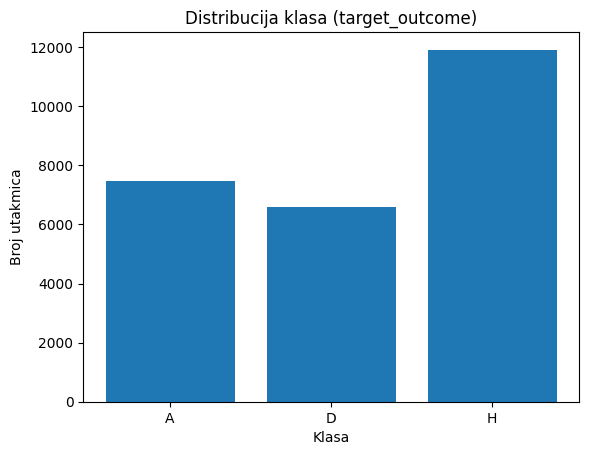

In [9]:
counts = y.value_counts().sort_index()  # A, D, H
plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Distribucija klasa (target_outcome)")
plt.xlabel("Klasa")
plt.ylabel("Broj utakmica")
plt.show()

plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Distribucija klasa (target_outcome)")
plt.xlabel("Klasa")
plt.ylabel("Broj utakmica")
plt.tight_layout()
plt.savefig("plot_class_distribution.png", dpi=200)
plt.close()


In [10]:
plt.figure()
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    labels=["A", "D", "H"],
    xticks_rotation=0,
    values_format="d"
)
plt.title("Confusion matrix (RandomForest)")
plt.tight_layout()
plt.show()

disp.figure_.savefig("plot_confusion_matrix.png", dpi=200)
plt.close(disp.figure_)


<Figure size 640x480 with 0 Axes>

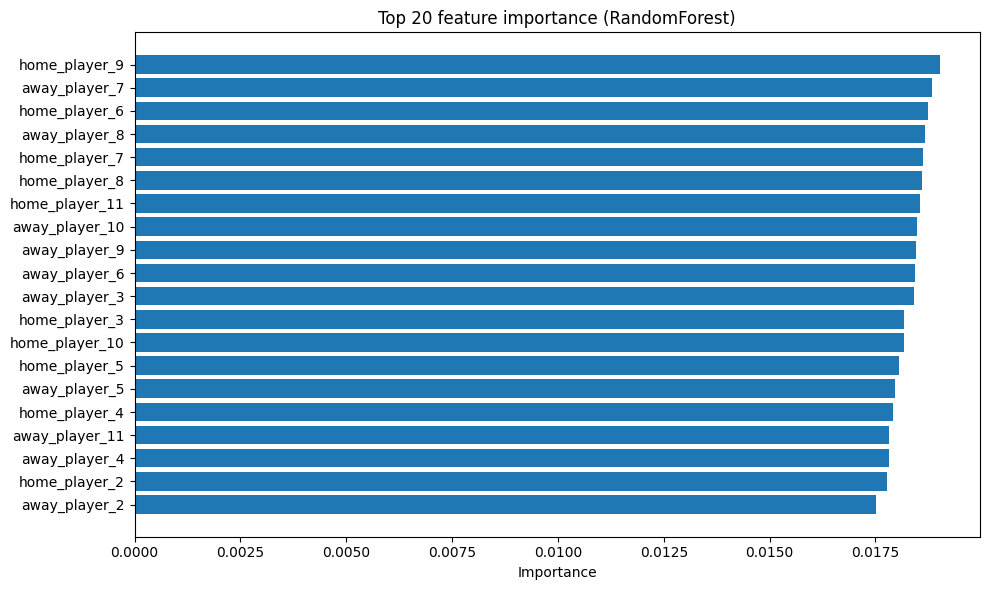

In [11]:
import pandas as pd

importances = pd.Series(model.feature_importances_, index=X.columns)
top = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top.index[::-1], top.values[::-1])
plt.title("Top 20 feature importance (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top.index[::-1], top.values[::-1])
plt.title("Top 20 feature importance (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("plot_feature_importance_top20.png", dpi=200)
plt.close()

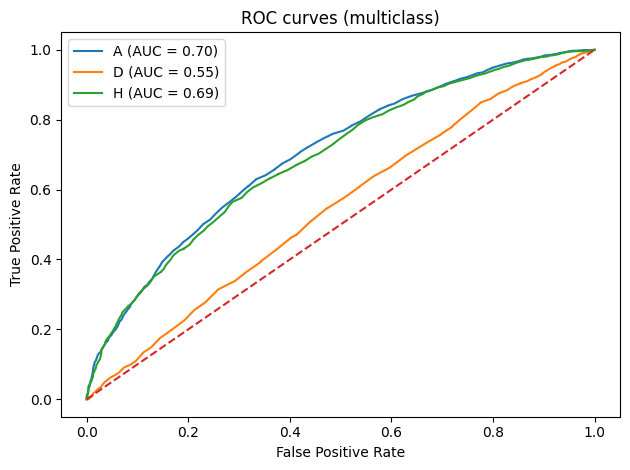

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

classes = ["A", "D", "H"]
y_test_bin = label_binarize(y_test, classes=classes)

y_proba = model.predict_proba(X_test)

plt.figure()

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (multiclass)")
plt.legend()
plt.tight_layout()
plt.show()

# spremi
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (multiclass)")
plt.legend()
plt.tight_layout()
plt.savefig("plot_roc_multiclass.png", dpi=200)
plt.close()

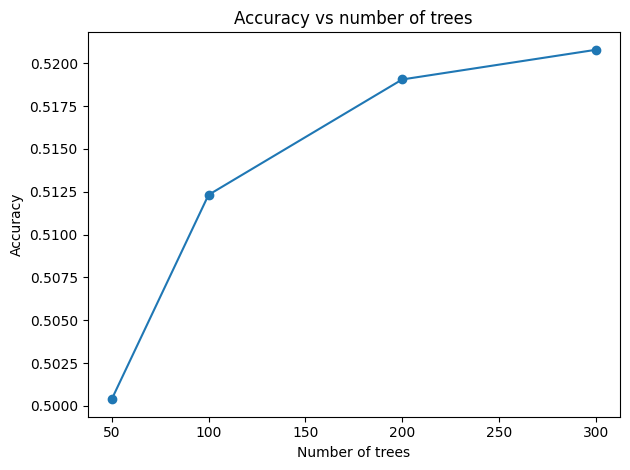

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

trees = [50, 100, 200, 300]
accs = []

for t in trees:
    m = RandomForestClassifier(n_estimators=t, random_state=42, n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    accs.append(accuracy_score(y_test, preds))

plt.figure()
plt.plot(trees, accs, marker="o")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of trees")
plt.tight_layout()
plt.show()

# spremi
plt.figure()
plt.plot(trees, accs, marker="o")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of trees")
plt.tight_layout()
plt.savefig("plot_accuracy_vs_trees.png", dpi=200)
plt.close()

In [14]:
import json
import joblib
import numpy as np
import pandas as pd

# Spremi listu featurea koje model očekuje (iz X.columns)
feature_names = list(X.columns)

score_py = f"""
import json
import joblib
import numpy as np
import pandas as pd

FEATURE_NAMES = {feature_names}

def init():
    global model
    model = joblib.load("rf_model.joblib")

def run(raw_data):
    try:
        data = json.loads(raw_data) if isinstance(raw_data, str) else raw_data

        # Očekujemo ili:
        # 1) {{"features": {{col: value, ...}}}}
        # 2) {{"inputs": [[v1, v2, ...]]}}
        if isinstance(data, dict) and "features" in data:
            row = [float(data["features"].get(c, 0.0)) for c in FEATURE_NAMES]
            X = np.array([row], dtype=float)
        elif isinstance(data, dict) and "inputs" in data:
            X = np.array(data["inputs"], dtype=float)
        else:
            return {{"error": "Invalid input. Use {{'features': {{...}}}} or {{'inputs': [[...]]}}."}}

        preds = model.predict(X).tolist()

        # ako postoji predict_proba
        proba = None
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X).tolist()

        return {{"prediction": preds, "proba": proba}}
    except Exception as e:
        return {{"error": str(e)}}
"""
with open("score.py", "w") as f:
    f.write(score_py)

"score.py created"


'score.py created'

In [15]:
import os
print("score.py exists:", os.path.exists("score.py"))
print("rf_model.joblib exists:", os.path.exists("rf_model.joblib"))


score.py exists: True
rf_model.joblib exists: True


In [16]:
# izbriši endpoint koji si zadnje napravio (ako postoji)
try:
    ml_client.online_endpoints.begin_delete(name="ep-nogomet-475211e1").result()
    print("Deleted ep-nogomet-475211e1")
except Exception as e:
    print("Skip delete (maybe doesn't exist):", e)


# Prvo vidi koje sve endpoint-e imaš
endpoints = ml_client.online_endpoints.list()
for endpoint in endpoints:
    print(f"Endpoint: {endpoint.name}")
    
    # Listaj sve deployment-e za svaki endpoint
    deployments = ml_client.online_deployments.list(endpoint.name)
    for deployment in deployments:
        print(f"  - Deployment: {deployment.name}, Status: {deployment.provisioning_state}")
        print(f"    Instance: {deployment.instance_type}, Count: {deployment.instance_count}")


Deleted ep-nogomet-475211e1
Endpoint: ep-nogomet-2ee9c394
  - Deployment: blue, Status: Failed
    Instance: Standard_F2s_v2, Count: 1
Endpoint: ep-nogomet-b72661b0
  - Deployment: blue, Status: Failed
    Instance: Standard_F2s_v2, Count: 1
Endpoint: ep-nogomet-32634ede
Endpoint: ep-nogomet-0a2690a5
  - Deployment: blue, Status: Failed
    Instance: Standard_F2s_v2, Count: 1
Endpoint: ep-nogomet-4175642b
Endpoint: ep-nogomet-ef4f8684
  - Deployment: blue, Status: Failed
    Instance: Standard_F4s_v2, Count: 1
Endpoint: ep-nogomet-e4f19ddc
  - Deployment: blue, Status: Failed
    Instance: Standard_F2s_v2, Count: 1
Endpoint: ep-nogomet-9267b0da
  - Deployment: blue, Status: Failed
    Instance: Standard_F2s_v2, Count: 1
Endpoint: ep-nogomet-74e323dd


In [17]:
import os, shutil

os.makedirs("deploy", exist_ok=True)

# kopiraj samo potrebne datoteke
for f in ["score.py", "conda.yml", "rf_model.joblib"]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing {f} in current folder")
    shutil.copy(f, os.path.join("deploy", f))

print("Deploy folder ready:", os.listdir("deploy"))


Deploy folder ready: ['conda.yml', 'rf_model.joblib', 'score.py']


In [18]:
from azure.ai.ml.entities import ManagedOnlineDeployment, Environment, CodeConfiguration

endpoint_name = "ep-nogomet-9267b0da"

env = Environment(
    name="env-nogomet-fixed",
    conda_file="deploy/conda.yml",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest"
)

deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,
    model=ml_client.models.get(name="nogomet_rf_model", version="2"),
    code_configuration=CodeConfiguration(code="deploy", scoring_script="score.py"),
    environment=env,
    instance_type="Standard_F2s_v2",
    instance_count=1
)

ml_client.online_deployments.begin_create_or_update(deployment).result()
print("Redeploy done")


Check: endpoint ep-nogomet-9267b0da exists


...................................

HttpResponseError: (BadArgument) User container has crashed or terminated. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready
Code: BadArgument
Message: User container has crashed or terminated. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready

In [ ]:
# pokaži sve online endpoint-e i njihove provisioning state
eps = list(ml_client.online_endpoints.list())
[(e.name, e.provisioning_state) for e in eps][-10:]


In [ ]:
# za zadnji endpoint iz liste (najnoviji) pročitaj detalje
last_ep = eps[-1].name
print("Last endpoint:", last_ep)
ep = ml_client.online_endpoints.get(last_ep)
print("Endpoint state:", ep.provisioning_state)


In [ ]:
# deployment-i za taj endpoint
deps = list(ml_client.online_deployments.list(endpoint_name=last_ep))
[(d.name, d.provisioning_state) for d in deps]


In [ ]:
if deps:
    dep = ml_client.online_deployments.get(name=deps[0].name, endpoint_name=last_ep)
    print("Deployment:", dep.name)
    print("State:", dep.provisioning_state)
    print("Instance type:", dep.instance_type)
    print("Environment:", dep.environment)


In [ ]:
# Simulacija endpointa: učitaj model + napravi predikciju iz score.py logike
import joblib, json
import numpy as np

loaded = joblib.load("rf_model.joblib")

sample = X_test.iloc[0].to_dict()
row = np.array([[float(sample.get(c, 0.0)) for c in X.columns]])

pred = loaded.predict(row)[0]
proba = loaded.predict_proba(row)[0].tolist()

pred, proba
